In [1]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import trigrams
from nltk import bigrams
from collections import Counter

import pandas as pd
import numpy as np
import os
import time
import csv
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare

import seaborn as sns
import matplotlib as plt
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy import stats
import sklearn.preprocessing

from bs4 import BeautifulSoup

df = prepare.wrangle_data()
df.info()

/Users/mindyshiben/codeup-data-science/nlp-project/prepare.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = clean_tokens.apply(stem)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627 entries, 0 to 2142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1627 non-null   object
 1   language         1627 non-null   object
 2   readme_contents  1627 non-null   object
 3   stemmed          1627 non-null   object
 4   lemmatized       1627 non-null   object
 5   total_words      1627 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 89.0+ KB


/Users/mindyshiben/codeup-data-science/nlp-project/prepare.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized'] = clean_tokens.apply(lemmatize)
/Users/mindyshiben/codeup-data-science/nlp-project/prepare.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_words'] = df['lemmatized'].str.split().str.len()


#### prepare notes-
- talk about handling nulls, decision to drop langs with < 10 records
- talk about steps to get lemmatized column

In [2]:
df = prepare.wrangle_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627 entries, 0 to 2142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1627 non-null   object
 1   language         1627 non-null   object
 2   readme_contents  1627 non-null   object
 3   stemmed          1627 non-null   object
 4   lemmatized       1627 non-null   object
 5   total_words      1627 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 89.0+ KB


In [4]:
df.language.value_counts()

JavaScript    600
HTML          396
Python        320
R             162
Java          149
Name: language, dtype: int64

#### show counts and percentage of languages

- put this in function

In [5]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

#maybe show this as histograms or count plots

,counts,percent
JavaScript,600,0.368777
HTML,396,0.243393
Python,320,0.196681
R,162,0.099570
Java,149,0.091580


In [6]:
#this is still prepare data, I am putting def clean into function, but can talk about
# how we picked the additional stop words (words that are high frequency words in 3 or more langs)

ADDITIONAL = ['The', 'I', 'This', 'app', 'run', 'project', 'user', 'use', 'mental', 'file', 'health',
       'create', 'page', 'code', 'also', 'help', 'used']
             
def clean(readme_contents):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL
    text = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    #words = re.sub(r'[^a-z\s]', '', text).split()
    words = re.sub (r'([^a-zA-Z ]+?)', "", text).split()
    #words = re.sub(r'[\D]', '', words).split()
    
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [7]:
#making dfs with clean function for all langs
JavaScript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
HTML_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
Python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
Java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
R_words = clean(' '.join(df[df.language == 'R'].readme_contents))
all_words = clean(' '.join(df.readme_contents))

In [8]:
all_words

['datasetsthe',
 'information',
 'evolving',
 'list',
 'data',
 'set',
 'primarily',
 'electronicsocial',
 'medium',
 'model',
 'mentalhealth',
 'phenomenon',
 'raw',
 'data',
 'additional',
 'column',
 'found',
 'datasourcesxlsx',
 'author',
 'paper',
 'feel',
 'anything',
 'misrepresented',
 'please',
 'hesitate',
 'reach',
 'kharrigianjhuedufor',
 'overview',
 'existing',
 'datasets',
 'please',
 'consider',
 'reading',
 'paper',
 'state',
 'social',
 'medium',
 'data',
 'researchhttpsarxivorgabsinproceedingsharrigianstate',
 'titleon',
 'state',
 'social',
 'medium',
 'data',
 'research',
 'authorharrigian',
 'keith',
 'aguirre',
 'carlos',
 'dredze',
 'mark',
 'booktitleproceedings',
 'th',
 'workshop',
 'computational',
 'linguistics',
 'clinical',
 'psychology',
 'improving',
 'access',
 'year',
 'contributingwe',
 'hope',
 'repository',
 'becomes',
 'central',
 'knowledge',
 'base',
 'researcher',
 'working',
 'intersection',
 'nlp',
 'however',
 'cannot',
 'achieve',
 'goal',


### hypos/questions

- QUESTION 1: do certain languages have a higher average readme word count than others?
- QUESTION 2: are certain frequently occuring words share across more than one language?
- QUESTION 3: what words, if any, are frequently occuring in readmes for certain langauges that are barely prevelant in other language readmes?
- QUESTION 4: Can small groups of sequential words (bigrams and trigrams) in readmes be predictive of the target variable?

<AxesSubplot:>

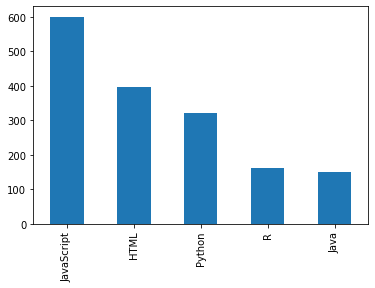

In [9]:
#this is redundant if you already show histograms or something
df.language.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='language'>

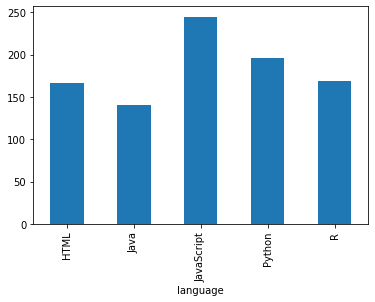

In [10]:
#shows total words distributed by langs. the graph below is better and we probably
# only need to use that one and not both
df.total_words.groupby(df.language).mean().plot(kind='bar')

### QUESTION 1

- do certain languages have a higher average readme word count than others?

   
   - in this section: 
            - make bins of high, med, and low readme word counts
            - graph these counts for comparison 
            - run T-test/s on language vs. total counts column
            - summarize findings

In [10]:
#show averages with group by:
df.total_words.groupby(df.language).mean().round()

language
HTML          167.0
Java          140.0
JavaScript    245.0
Python        196.0
R             169.0
Name: total_words, dtype: float64

In [11]:
#prep to make bins for the better visual
conditions = [(df.total_words > 171),
              (df.total_words >= 51) & (df.total_words <= 171),
              (df.total_words < 51)]
choices = ['high_count', 'med_count', 'low_count']

df['count_bin'] = np.select(conditions, choices)

In [12]:
df_plot = df.groupby(['language', 'count_bin']).size().reset_index().pivot(columns='count_bin', index='language', values=0)

<AxesSubplot:xlabel='language'>

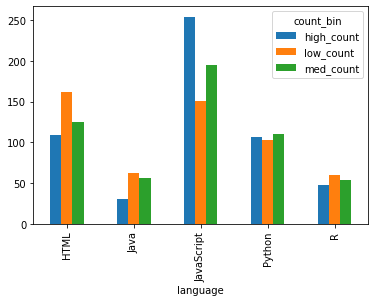

In [14]:
#I like this to show lang counts with bins

df_plot.plot(kind='bar')

### QUESTION 1 STATS (place holder)

### QUESTION 1 summary

- do certain languages have a higher average readme word count than others?

On average, Java readmes have the lowest total words whereas JavaScript has the highest. JavaScript readmes have considerably more words than the other 4 programing languages. 

#### add other takeaway w/stat test results

### QUESTION 2: 
- are certain frequently occuring words share across more than one language?

   - in this section: 
   
            - make a top_words dataframe that includes the top 20 most frequently occuring words in each language
            - see if any of of a language's top 20 readme words (not including stopwords) are shared with other language's/s' top 20
            - summarize findings

In [13]:
#make dfs to show frequencies of words

JavaScript_freq = pd.Series(JavaScript_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
R_freq = pd.Series(R_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [14]:
word_counts = (pd.concat([all_freq, JavaScript_freq, HTML_freq, Python_freq, 
                    Java_freq, R_freq], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [15]:
#shows 20 top words- could show less is fine (important to note after the stop words have been removed)
#arranged by all words
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,Java,R
data,1883,368,399,531,80,505
using,1477,666,264,331,127,89
build,1475,1268,90,54,41,22
npm,1348,1207,93,15,33,0
react,1302,1209,47,22,24,0
section,1130,843,219,42,8,18
test,1115,782,125,127,55,26
user,1043,482,216,187,141,17
feature,1015,520,147,264,63,21
install,973,573,113,218,36,33


In [16]:
#makes dfs for arranging top words by the diff langs to help compare
#if tops in some langs may be way different than tops in others
js_top = word_counts.sort_values(by='JavaScript', ascending=False).head(20)
html_top = word_counts.sort_values(by='HTML', ascending=False).head(20)
python_top = word_counts.sort_values(by='Python', ascending=False).head(20)
java_top = word_counts.sort_values(by='Java', ascending=False).head(20)
r_top = word_counts.sort_values(by='R', ascending=False).head(20)

In [17]:
#makes one df of the top 20 words in all dfs 
top_words = (pd.concat([js_top, html_top, python_top, java_top,
                    r_top], axis=0, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

top_words.head()

,HTML,Java,JavaScript,Python,R,all
build,90,41,1268,54,22,1475
react,47,24,1209,22,0,1302
npm,93,33,1207,15,0,1348
section,219,8,843,42,18,1130
test,125,55,782,127,26,1115


In [18]:
#drops all as we don't need that to compare for next step
top_words= top_words.drop(columns=['all'])

In [19]:
#if you want to graph somehow, but not super necessary to include this
top_words

,HTML,Java,JavaScript,Python,R
build,90,41,1268,54,22
react,47,24,1209,22,0
npm,93,33,1207,15,0
section,219,8,843,42,18
test,125,55,782,127,26
...,...,...,...,...,...
using,264,127,666,331,89
tech,89,3,86,44,81
width,66,22,129,31,76
folder,72,14,318,92,73


In [22]:
#this is what we used to determine other stop words for clean function. I
#don't think this needs to be here bc it wouldn't be right for flow,
#and we already took the unique word list to that function. just for you to have
#incase it helps with explaining the previous function
# I think we could use the one below this one to answer the question though
tops = top_words[top_words.index.value_counts() > 2]
tops.index.unique()

/var/folders/s4/hmz6ljm533vgpm_bhv59yw0m0000gn/T/ipykernel_83326/3463428680.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tops = top_words[top_words.index.value_counts() > 2]


Index(['using', 'need', 'feature', 'user', 'time', 'information', 'file',
       'data'],
      dtype='object')

In [20]:
#these are the frequent words that are shared amongst 2 or more programming languages
tops = top_words[top_words.index.value_counts() > 1]
tops.index.unique()

/var/folders/s4/hmz6ljm533vgpm_bhv59yw0m0000gn/T/ipykernel_38705/1324539588.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tops = top_words[top_words.index.value_counts() > 1]


Index(['section', 'test', 'using', 'install', 'make', 'need', 'feature',
       'user', 'time', 'information', 'file', 'data', 'people', 'one',
       'application', 'model', 'analysis', 'dataset'],
      dtype='object')

### QUESTION 2 summary: 

- are certain frequently occuring words share across more than one language?

The following words are amongst the top 20 frequently occuring words (excluding stop words) in 2 or more languages:

'section', 'test', 'install', 'make', 'need', 'feature', 'user', 'time',
       'information', 'file', 'command', 'people', 'one', 'application',
       'model', 'dataset', 'analysis', 'following'

### QUESTION 3: 
- what words, if any, are frequently occuring in readmes for certain langauges that are barely prevelant in other language readmes?

   - in this section: 
   
            NOT THIS LINE WITH UPDATE (- make dfs (divided for graphing) that looks at the top 20 most frequently occuring words (in all records))
            -use the "word_counts" df to create a new df of top 20 most frequently occuring words with percentages per language - shows word prevelance of particular languages
            - graph the relationships
            - run statistical tests to see what top words, if any, have a significant frequency difference in different languages
            - summarize findings

In [21]:
#making the new df with top counts
most_freq = (word_counts[word_counts['all'] > 730])

In [22]:
#changing df to show percentages and transposing to visualize best

word_perc = pd.DataFrame()
for col in most_freq.columns:
    word_perc = word_perc.append(most_freq[col].sort_values(ascending=False)/most_freq[col].sum())

word_perc_T = word_perc.T
word_perc_T = word_perc_T
word_perc_T = word_perc_T.drop(columns=['all'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual
word_perc_T

,JavaScript,HTML,Python,Java,R
data,0.030058,0.116667,0.174959,0.066007,0.440279
using,0.054398,0.077193,0.109061,0.104785,0.077594
build,0.103569,0.026316,0.017792,0.033828,0.019180
npm,0.098587,0.027193,0.004942,0.027228,0.000000
react,0.098750,0.013743,0.007249,0.019802,0.000000
section,0.068856,0.064035,0.013839,0.006601,0.015693
test,0.063873,0.036550,0.041845,0.045380,0.022668
user,0.039369,0.063158,0.061614,0.116337,0.014821
feature,0.042473,0.042982,0.086985,0.051980,0.018309
install,0.046802,0.033041,0.071829,0.029703,0.028771


In [33]:
#THIS WHOLE BLOCK CAN BE IGNORED
#just makes dfs of some of the most freq words. divided like this just to make graphs
#look nicer
#most_freq_700 is 700-799 words
#most_freq_800 is 800-999 words
#most_freq is is 1000+
# most_freq_700 = word_counts[word_counts['all'] > 700] 
# most_freq_700 = most_freq_700[most_freq_700['all'] < 800]
# most_freq_800 = word_counts[word_counts['all'] >= 800]
# most_freq_800 = most_freq_800[most_freq_800['all'] < 1000]
# most_freq = word_counts[word_counts['all'] >= 700]

In [34]:
#IGNORE BLOCK
#making dfs to look at these as a percentage and give each language
#equal weight looking at word importance as our records are evenly 
#distributed


# TAKING OUT word_perc_700 = pd.DataFrame()
#for col in most_freq_700.columns:
    #word_perc_700 = word_perc_700.append(most_freq_700[col].sort_values(ascending=False)/most_freq_700[col].sum())
    
#TAKING OUT word_perc_800 = pd.DataFrame()
#for col in most_freq_800.columns:
  #  word_perc_800 = word_perc_800.append(most_freq_800[col].sort_values(ascending=False)/most_freq_800[col].sum())

In [77]:
#IGNORE BLOCK
#TAKING OUT
#incase we wanted to use the counts (can do with the 3 most_freq dfs, but I
#think we could skip this and just do the word_perc dfs for the graphs
#as I think they are more meaningful)
#plt.rcParams["figure.figsize"] = (20,10)
#most_freq.plot(kind='bar')

Text(0.5, 1.0, 'Proportion of languages for the 20 most common words')

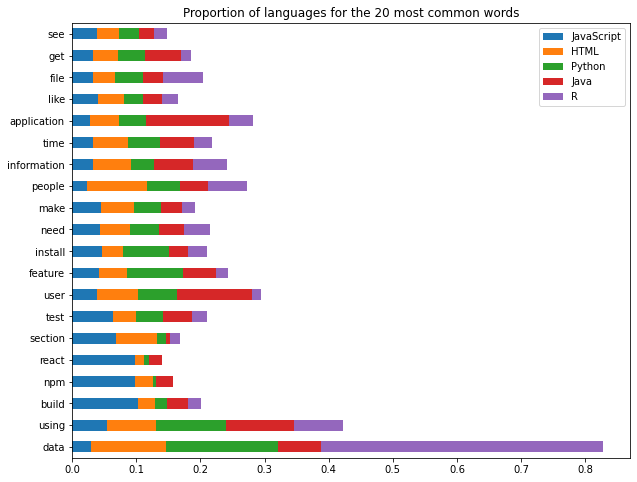

In [23]:
plt.rcParams["figure.figsize"] = (10,8)
word_perc_T.plot(kind = 'barh', stacked=True)
plt.title('Proportion of languages for the 20 most common words')

to look at similarities, we simple look at bars w similar heights. That will show they have a similar distribution of that specific word

### QUESTION 3 summary: 

- what words, if any, are frequently occuring in readmes for certain langauges that are barely prevelant in other language readmes?

Looking at graphs (and stat tests), these top occuring words may be helpful in identifying said languages:

- 'data': R
- 'file': R
- 'website': HTML
- 'application': Java
- 'react', 'build', 'npm': JavaScript

### Question 4 
Can small groups of sequential words (bigrams and trigrams) in readmes be predictive of the target variable?

Text(0.5, 1.0, 'Proportion of languages for the 20 most common bigrams')

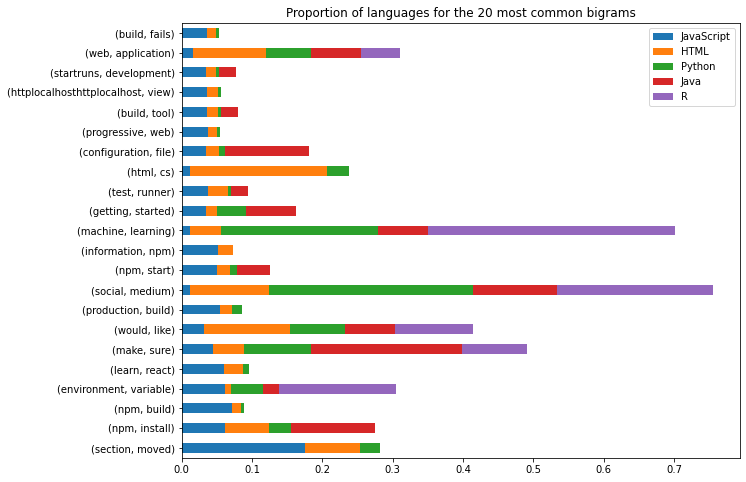

In [71]:
#this shows the 20 top most frequently occuring birgrams

bigrams_all = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts())
bigrams_JavaScript = (pd.Series(nltk.ngrams(JavaScript_words, 2))
                      .value_counts())
bigrams_HTML = (pd.Series(nltk.ngrams(HTML_words, 2))
                      .value_counts())
bigrams_Python = (pd.Series(nltk.ngrams(Python_words, 2))
                      .value_counts())
bigrams_Java = (pd.Series(nltk.ngrams(Java_words, 2))
                      .value_counts())
bigrams_R = (pd.Series(nltk.ngrams(R_words, 2))
                      .value_counts())

bigram_counts = (pd.concat([bigrams_all, bigrams_JavaScript, bigrams_HTML, bigrams_Python, 
                    bigrams_Java, bigrams_R], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

most_freq_bigrams = (bigram_counts[bigram_counts['all'] >= 105])

word_perc_bigrams = pd.DataFrame()
for col in most_freq_bigrams.columns:
    word_perc_bigrams = word_perc_bigrams.append(most_freq_bigrams[col].sort_values(ascending=False)/most_freq_bigrams[col].sum())

word_perc_bigrams_T = word_perc_bigrams.T
word_perc_bigrams_T = word_perc_bigrams_T.drop(columns=['all'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual

plt.rcParams["figure.figsize"] = (10,8)
word_perc_bigrams_T.plot(kind = 'barh', stacked=True)
plt.title('Proportion of languages for the 20 most common bigrams')

Text(0.5, 1.0, 'High Frequency Bigrams of Languages Compared')

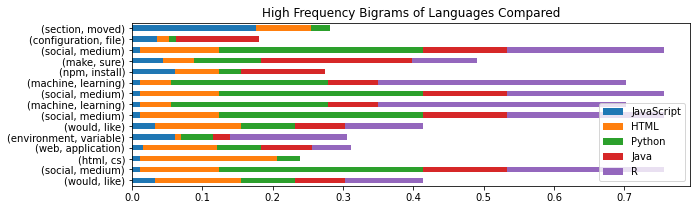

In [114]:
#This shows bigrams that have higher distribution (above 10%) in a certain languages
#this can be used to show what bigrams may be most predictive regardless of
#overall frequency
Java_high = word_perc_bigrams_T[word_perc_bigrams_T.Java > .1]
Python_high = word_perc_bigrams_T[word_perc_bigrams_T.Python > .1]
R_high = word_perc_bigrams_T[word_perc_bigrams_T.R > .1]
HTML_high = word_perc_bigrams_T[word_perc_bigrams_T.HTML > .1]
js_high = word_perc_bigrams_T[word_perc_bigrams_T.JavaScript > .1]

langs_high_tris = pd.concat([HTML_high, R_high, Python_high, Java_high, js_high])

plt.rcParams["figure.figsize"] = (10,3)
langs_high_tris.plot(kind = 'barh', stacked=True)
plt.title('High Frequency Bigrams of Languages Compared')

### Bigram takeaways- 
Here this graph shows the most useful bigrams, although many of the most indentifying bigrams are shared with 2 or more languages. 

Therefore, we will attempt to build on the notion of grouping words together for prective potential and explore the value of trigrams.

Text(0.5, 1.0, 'High Frequency Trigrams of Languages Compared')

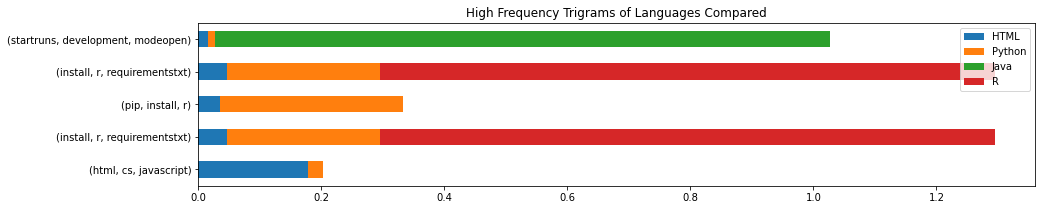

In [146]:
#This shows trigrams that have higher distribution (above 5%) in a certain languages
#this can be used to show what trigrams may be most predictive regardless of
#overall frequency
#note: high frequency trigrams are very evenly distributed across
#languages therefore the high frequency trigrams are not shown as there 
#is no potential predictivity there 

trigrams_all = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts())
trigrams_JavaScript = (pd.Series(nltk.ngrams(JavaScript_words, 3))
                      .value_counts())
trigrams_HTML = (pd.Series(nltk.ngrams(HTML_words, 3))
                      .value_counts())
trigrams_Python = (pd.Series(nltk.ngrams(Python_words, 3))
                      .value_counts())
trigrams_Java = (pd.Series(nltk.ngrams(Java_words, 3))
                      .value_counts())
trigrams_R = (pd.Series(nltk.ngrams(R_words, 3))
                      .value_counts())

trigram_counts = (pd.concat([trigrams_all, trigrams_HTML, trigrams_Python, 
                    trigrams_Java, trigrams_R], axis=1, sort=True)
                .set_axis(['all', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

most_freq_trigrams = (trigram_counts[trigram_counts['all'] >= 30 ])
most_freq_trigrams = (most_freq_trigrams[most_freq_trigrams['all'] < 60])

word_perc_trigrams = pd.DataFrame()
for col in most_freq_trigrams.columns:
    word_perc_trigrams = word_perc_trigrams.append(most_freq_trigrams[col].sort_values(ascending=False)/most_freq_trigrams[col].sum())

word_perc_trigrams_T = word_perc_trigrams.T
word_perc_trigrams_T = word_perc_trigrams_T.drop(columns=['all'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual

Java_high = word_perc_trigrams_T[word_perc_trigrams_T.Java > .05]
Python_high = word_perc_trigrams_T[word_perc_trigrams_T.Python > .05]
R_high = word_perc_trigrams_T[word_perc_trigrams_T.R > .05]
HTML_high = word_perc_trigrams_T[word_perc_trigrams_T.HTML > .05]

langs_high_tris = pd.concat([HTML_high, R_high, Python_high, Java_high])

plt.rcParams["figure.figsize"] = (15,3)
langs_high_tris.plot(kind = 'barh', stacked=True)
plt.title('High Frequency Trigrams of Languages Compared')


In [132]:
langs_high_tris.index.unique()

Index([            ('html', 'cs', 'javascript'),
            ('install', 'r', 'requirementstxt'),
                        ('pip', 'install', 'r'),
       ('startruns', 'development', 'modeopen')],
      dtype='object')

In [147]:
tri_counts = trigram_counts[(trigram_counts.index == ('html', 'cs', 'javascript')) |
(trigram_counts.index == ('install', 'r', 'requirementstxt')) |
(trigram_counts.index == ('pip', 'install', 'r')) |
(trigram_counts.index == ('install', 'r', 'requirementstxt')) |
(trigram_counts.index == ('startruns', 'development', 'modeopen'))]
tri_counts

,,,all,HTML,Python,Java,R
html,cs,javascript,50,35,2,0,0
install,r,requirementstxt,38,9,21,0,1
pip,install,r,41,7,25,0,0
startruns,development,modeopen,58,3,1,1,0


In [ ]:
observed = pd.DataFrame([[100, 50], [120, 28]]

In [162]:
trigrams_Python.sum()

57710

In [161]:
index = ['all', 'HTML']
columns = ['total_words', 'trigram']

html_cs_javascript = pd.DataFrame([[302457, 50], [60208, 35]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('we reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we reject the null hypothesis


In [163]:
index = ['all', 'Python']
columns = ['total_words', 'trigram']

html_cs_javascript = pd.DataFrame([[302457, 38], [57710, 21]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('we reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we reject the null hypothesis


In [164]:
index = ['all', 'Python']
columns = ['total_words', 'trigram']

html_cs_javascript = pd.DataFrame([[302457, 41], [57710, 25]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('we reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we reject the null hypothesis


In [165]:
index = ['all', 'Python']
columns = ['total_words', 'trigram']

html_cs_javascript = pd.DataFrame([[302457, 58], [60208, 3]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('we reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we reject the null hypothesis


### Trigram takeaways- 
Here this graph shows the most useful trigrams. JavaScript does not have any highly predictive trigrams, but the other four languages so have at least one trigram that seems to set them apart.

The 5 trigrams that showed the most predictive potential also all performed well in chi squared testing confirming these 5 trigrams are likely useful in predicting the target

### Exploration Summary

#### QUESTION 1

Do certain languages have a higher average readme word count than others?

>-  On average, Java readmes have the lowest total words whereas JavaScript has the highest. JavaScript readmes have considerably more words than the other 4 programing languages. 

####  QUESTION 2 

Are certain frequently occuring words share across more than one language?

>- The following words are amongst the top 20 frequently occuring words (excluding stop words) in 2 or more languages:
'section', 'test', 'install', 'make', 'need', 'feature', 'user', 'time',
'information', 'file', 'command', 'people', 'one', 'application','model', 'dataset', 'analysis', 'following'

#### QUESTION 3 
What words, if any, are frequently occuring in readmes for certain langauges that are barely prevelant in other language readmes?

>- Looking at graphs (and stat tests), these top occuring words may be helpful in identifying said languages:
    - 'data': R
    - 'file': R
    - 'website': HTML
    - 'application': Java
    - 'react', 'build', 'npm': JavaScript

### Question 4 
Can small groups of sequential words (bigrams and trigrams) in readmes be predictive of the target variable?

>- Many of the most indentifying bigrams are shared with 2 or more languages, yet the 5 trigrams that showed the most predictive potential of the target which has been confirmed with chi squared testing. Four out of the five languages seem to have a predictive trigram (a useful JavaScript trigram was not seen).
    

# END 

In [ ]:
jkasbdflaksbdc

In [83]:
trigram_counts['all'].sort_values(ascending=False).head(20)

httplocalhosthttplocalhost  view         browserthe     102
browserthe                  reload       make           101
see                         lint         error          101
lint                        error        console        101
view                        browserthe   reload         101
available                   scriptsin    directory      100
buildbuilds                 production   build           99
testlaunches                test         runner          98
making                      progressive  web             98
production                  mode         optimizes       98
test                        runner       interactive     98
bundle                      react        production      98
runner                      interactive  watch           98
optimizes                   build        best            98
mode                        optimizes    build           98
correctly                   bundle       react           98
react                       production  

In [32]:
bigram_counts = (pd.concat([bigrams_all, bigrams_JavaScript, bigrams_HTML, bigrams_Python, 
                    bigrams_Java, bigrams_R], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [72]:
trigrams_all = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts())

(httplocalhosthttplocalhost, view, browserthe)    102
(browserthe, reload, make)                        101
(lint, error, console)                            101
(view, browserthe, reload)                        101
(see, lint, error)                                101
                                                 ... 
(one, j, html)                                      1
(j, html, asset)                                    1
(html, asset, drag)                                 1
(asset, drag, asset)                                1
(pupil, regularly, efficiently)                     1
Length: 220665, dtype: int64

In [45]:
bigram_counts['all'].sort_values(ascending=False).head(20)

section                     moved       527
npm                         install     206
                            build       205
environment                 variable    195
learn                       react       181
make                        sure        175
would                       like        162
production                  build       160
social                      medium      156
npm                         start       153
information                 npm         152
machine                     learning    120
getting                     started     116
test                        runner      116
html                        cs          113
configuration               file        111
progressive                 web         110
build                       tool        109
httplocalhosthttplocalhost  view        108
build                       fails       105
Name: all, dtype: int64

In [46]:
most_freq_bigrams = (bigram_counts[bigram_counts['all'] >= 105])

In [47]:
most_freq_bigrams

all  JavaScript  HTML  Python  Java  \
build                      fails        105          99     5       1     0   
                           tool         109         101     6       1     1   
configuration              file         111          97     7       2     5   
environment                variable     195         172     3      10     1   
getting                    started      116          98     6       9     3   
html                       cs           113          31    75       7     0   
httplocalhosthttplocalhost view         108         101     6       1     0   
information                npm          152         144     8       0     0   
learn                      react        181         169    10       2     0   
machine                    learning     120          32    17      49     3   
make                       sure         175         123    17      21     9   
npm                        build        205         199     5       1     0   
                           install      206         170    24       7     5   
                           start        153         142     7       2     2   
production                 build        160         150     7       3     0   
progressive                web          110         104     5       1     0   
section                    moved        527         491    30       6     0   
social                     medium       156          32    43      64     5   
startruns                  development  105          98     5       1     1   
test                       runner       116         103    11       1     1   
web                        application  105          45    40      14     3   
would                      like         162          89    47      17     3   

                                         R  
build                      fails         0  
                           tool          0  
configuration              file          0  
environment                variable      9  
getting                    started       0  
html                       cs            0  
httplocalhosthttplocalhost view          0  
information                npm           0  
learn                      react         0  
machine                    learning     19  
make                       sure          5  
npm                        build         0  
                           install       0  
                           start         0  
production                 build         0  
progressive                web           0  
section                    moved         0  
social                     medium       12  
startruns                  development   0  
test                       runner        0  
web                        application   3  
would                      like          6

In [50]:
word_perc_bigrams = pd.DataFrame()
for col in most_freq_bigrams.columns:
    word_perc_bigrams = word_perc_bigrams.append(most_freq_bigrams[col].sort_values(ascending=False)/most_freq_bigrams[col].sum())

word_perc_bigrams_T = word_perc_bigrams.T
word_perc_bigrams_T = word_perc_bigrams_T.drop(columns=['all'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual
word_perc_bigrams_T

,JavaScript,HTML,Python,Java,R
"(section, moved)",0.175986,0.078125,0.027273,0.000000,0.000000
"(npm, install)",0.060932,0.062500,0.031818,0.119048,0.000000
"(npm, build)",0.071326,0.013021,0.004545,0.000000,0.000000
"(environment, variable)",0.061649,0.007812,0.045455,0.023810,0.166667
"(learn, react)",0.060573,0.026042,0.009091,0.000000,0.000000
"(make, sure)",0.044086,0.044271,0.095455,0.214286,0.092593
"(would, like)",0.031900,0.122396,0.077273,0.071429,0.111111
"(production, build)",0.053763,0.018229,0.013636,0.000000,0.000000
"(social, medium)",0.011470,0.111979,0.290909,0.119048,0.222222
"(npm, start)",0.050896,0.018229,0.009091,0.047619,0.000000


Text(0.5, 1.0, 'Proportion of languages for the 20 most common bigrams')

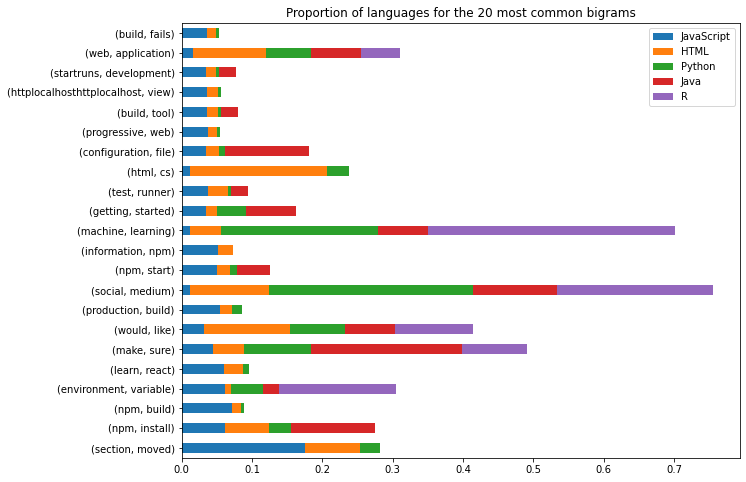

In [53]:
plt.rcParams["figure.figsize"] = (10,8)
word_perc_bigrams_T.plot(kind = 'barh', stacked=True)
plt.title('Proportion of languages for the 20 most common bigrams')

- H0
    : Mean of (section, moved) distribution in JavaScript <= Mean of (section, moved) of all languages

- Ha
    :  Mean of (section, moved) distribution in JavaScript > Mean of (section, moved) of all languages

In [66]:
word_perc_bigrams_T.index.unique()

Index([                  ('section', 'moved'),
                           ('npm', 'install'),
                             ('npm', 'build'),
                  ('environment', 'variable'),
                           ('learn', 'react'),
                             ('make', 'sure'),
                            ('would', 'like'),
                      ('production', 'build'),
                         ('social', 'medium'),
                             ('npm', 'start'),
                       ('information', 'npm'),
                      ('machine', 'learning'),
                       ('getting', 'started'),
                           ('test', 'runner'),
                               ('html', 'cs'),
                    ('configuration', 'file'),
                       ('progressive', 'web'),
                            ('build', 'tool'),
       ('httplocalhosthttplocalhost', 'view'),
                 ('startruns', 'development'),
                       ('web', 'application'),
             

In [ ]:
#10 most common trigrams
top = tri_counts.most_common(10)
print (top)

#20 most common bis
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head(20)

### QUESTION 4: 
(I re-worded this question)
- Are the most frequently occuring words predictive of the programming language?
- Chi Squared Test (I'll also add this for bigrams and tris)

-H0 : The top 20 most frequently occuring words are independent of the programming language

-Ha : The top 20 most frequently occuring words are not independent of the programming language

In [207]:
chi2, p, degf, expected = stats.chi2_contingency(word_perc)

print('Observed\n')
print(word_perc.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[0.0811533  0.06365556 0.06356937 0.05809594 0.05611343 0.0487006
  0.04805413 0.04495108 0.04374434 0.04193423 0.03999483 0.03960695
  0.03840021 0.0365901  0.03628841 0.03581433 0.03396113 0.03292678
  0.03202172 0.03193553 0.03120286 0.03094427 0.0303409 ]
 [0.02755935 0.04987643 0.09495993 0.09039167 0.09054145 0.06313188
  0.05856362 0.03609676 0.03894256 0.04291171 0.04036546 0.0414888
  0.0221673  0.03033026 0.03070471 0.02643601 0.03707032 0.03025537
  0.0293567  0.03572231 0.01587658 0.03841833 0.02883247]
 [0.09665698 0.06395349 0.02180233 0.02252907 0.01138566 0.05305233
  0.03028101 0.05232558 0.03561047 0.02737403 0.03875969 0.04312016
  0.07703488 0.04917636 0.04481589 0.03633721 0.03318798 0.02882752
  0.03343023 0.02882752 0.10828488 0.01744186 0.04578488]
 [0.16333436 0.10181483 0.01661027 0.00461396 0.00676715 0.0129191
  0.0390649  0.05752076 0.08120578 0.06705629 0.04152568 0.03814211
  0.04767764 0.03260535 0.04675484 0.0393725  0.02829898 0.04060289
  0

### we fail to reject the null...
- I will do this for bis and tris before writing the takeaway

In [208]:
# stopping point. I think that's mostly all for EDA other than adding bis and tris and L's images

In [310]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,Java,R
data,1883,368,399,531,80,505
using,1477,666,264,331,127,89
build,1475,1268,90,54,41,22
npm,1348,1207,93,15,33,0
react,1302,1209,47,22,24,0
section,1130,843,219,42,8,18
test,1115,782,125,127,55,26
user,1043,482,216,187,141,17
feature,1015,520,147,264,63,21
install,973,573,113,218,36,33


In [213]:
(word_counts[word_counts['all'] > 730]

all           7.387139
JavaScript    3.366305
HTML          1.470545
Python        1.409535
Java          0.463023
R             0.677731
dtype: float64

In [300]:
most_freq = (word_counts[word_counts['all'] < 120])
#most_freq = (most_freq[most_freq['all'] > 118])
most_freq = word_counts.T
#word_perc = pd.DataFrame()
#for col in most_freq.columns:
#word_perc = word_perc.approach.sort_values(ascending=False)/most_freq['approach'].sum()
word_perc = most_freq.approach.sort_values(ascending=False)/most_freq['approach'].sum()

In [306]:
df 

,repo,language,readme_contents,stemmed,lemmatized,total_words
0,kharrigian/mental-health-datasets,Python,\n# Mental Health Datasets\n\nThe information ...,mental health datasetsth inform evolv list dat...,mental health datasetsthe information evolving...,2716
1,behavioral-data/Empathy-Mental-Health,Python,# Empathy in Text-based Mental Health Support\...,empathi textbas mental health supportthi repos...,empathy textbased mental health supportthis re...,400
2,stutisehgal/RASA-Mental-Health-Chatbot,Python,# RASA-Mental-Health-Chatbot\n\nMental health ...,rasamentalhealthchatbotment health chatbot dev...,rasamentalhealthchatbotmental health chatbot d...,55
3,openeobs/openeobs,Python,# Open-eObs\n[![Codacy Badge](https://api.coda...,openeobscodaci badgeutmmediumreferralamputmcon...,openeobscodacy badgeutmmediumreferralamputmcon...,223
4,kharrigian/mental-health-keywords,Python,# Mental Health Keywords for Twitter\n\nThis r...,mental health keyword twitterthi repositori co...,mental health keywords twitterthis repository ...,468
...,...,...,...,...,...,...
2137,Imran-2022/BOOK-ECOMMERCE,JavaScript,##### [BOOK-eCOMMERCE (MERN WEB)](http://local...,bookecommerc mern webhttplocalhost3001 technol...,bookecommerce mern webhttplocalhost3001 techno...,51
2138,Levodex/RipplerPy,JavaScript,## About\n* \n* (Read github/bitbucket descrip...,read githubbitbucket descript copyright notice...,read githubbitbucket description copyright not...,155
2139,GVCL/DemographicVis,JavaScript,# DemogrphicVis\nThe interactive visualization...,demogrphicvisth interact visual tool demograph...,demogrphicvisthe interactive visualization too...,110
2141,Kingbond470/Herbal-Tea-Website,JavaScript,# Herbal-Tea-Website\n\nIt will show the basic...,herbalteawebsiteit show basic info herbal teah...,herbalteawebsiteit show basic info herbal teah...,86


In [303]:
word_perc = word_perc[word_perc.index != 'JavaScript']
word_perc = word_perc[word_perc.index != 'HTML']
word_perc = word_perc[word_perc.index != 'Python']
word_perc = word_perc[word_perc.index != 'Java']

In [330]:
word_perc = (word_counts[word_counts['all'] > 1500])

In [331]:
word_perc = word_perc.T

In [333]:
word_perc = word_perc[word_perc.index != 'JavaScript']
word_perc = word_perc[word_perc.index != 'HTML']
word_perc = word_perc[word_perc.index != 'Python']
word_perc = word_perc[word_perc.index != 'Java']

In [334]:
does have the word data, does not have the word data

,data
all,1883
R,505


In [361]:
df['total_words'].where(df.language != 'R').sum()

296616.0

In [362]:
word_perc = (word_counts[word_counts['all'] > 1000])

In [365]:
word_perc['not_R'] = word_perc['all'] - word_perc['R']

/var/folders/s4/hmz6ljm533vgpm_bhv59yw0m0000gn/T/ipykernel_83326/3567054369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_perc['not_R'] = word_perc['all'] - word_perc['R']


In [366]:
word_perc

,all,JavaScript,HTML,Python,Java,R,not_R
build,1475,1268,90,54,41,22,1453
data,1883,368,399,531,80,505,1378
feature,1015,520,147,264,63,21,994
npm,1348,1207,93,15,33,0,1348
react,1302,1209,47,22,24,0,1302
section,1130,843,219,42,8,18,1112
test,1115,782,125,127,55,26,1089
user,1043,482,216,187,141,17,1026
using,1477,666,264,331,127,89,1388


In [409]:
df.total_words.where(df.language!='Python').sum()
#are langs less likely to contain freq words
#word_perc['all'] - word_perc.Python).sum()

261349.0

In [403]:
index = ['R', 'html', 'js', 'java', 'python']
columns = ['freq', 'total']

observed = pd.DataFrame([[698, 27449], [1600, 66168], [7345 ,146816], [572, 20916], [1573,62716]], index=index, columns=columns)

In [410]:
index = ['not_python', 'python']
columns = ['freq', 'total']

observed = pd.DataFrame([[10215,261349], [1573,62716]], index=index, columns=columns)

In [417]:
word_counts

,all,JavaScript,HTML,Python,Java,R
aa,2,0,1,0,1,0
aaa,1,0,0,0,1,0
aaaa,3,0,0,1,0,2
aac,1,0,0,0,1,0
aachal,2,2,0,0,0,0
...,...,...,...,...,...,...
zvolit,1,0,0,0,0,1
zvsedanogmailcom,1,1,0,0,0,0
zyscarletmailrutgersedu,1,1,0,0,0,0
zzzr,1,0,0,0,0,1


In [413]:
for lang in df.language:
    total_not = df.total_words.where(df.language!= (lang)).sum()
    total_lang = df.total_words.where(df.language== (lang)).sum()


# index = ['not_python', 'python']
# columns = ['freq', 'total']

# observed = pd.DataFrame([[10215,261349], [1573,62716]], index=index, columns=columns)

In [421]:
from scipy.stats import chisquare

In [476]:
words = word_counts[word_counts['all'] > 100]

In [468]:
df['total_words'].groupby(df.language).sum()

language
HTML           66168
Java           20916
JavaScript    146816
Python         62716
R              27449
Name: total_words, dtype: int64

In [452]:
#words = words.drop(columns=['all'])

In [459]:
totals = df['total_words'].groupby(df.language).sum()

In [469]:
totals = pd.DataFrame(totals)

In [475]:
totals['all'] = totals.sum(axis=1)

In [477]:
new = pd.concat([totals, words])
new

,HTML,Java,JavaScript,Python,R,all
total_words,66168,20916,146816,62716,27449,324065
aachol,0,0,102,0,0,102
able,93,46,132,51,9,331
access,92,23,154,51,31,351
account,24,19,101,39,7,190
...,...,...,...,...,...,...
year,73,14,57,60,37,241
youll,21,7,67,6,2,103
young,28,3,58,18,10,117
youre,17,12,180,12,3,224


In [478]:
#make columns not
new['not_HTML'] = new['all'] - new['HTML']
new['not_Java'] = new['all'] - new['Java']
new['not_JavaScript'] = new['all'] - new['JavaScript']
new['not_Python'] = new['all'] - new['Python']
new['not_R'] = new['all'] - new['R']

In [484]:
pd.

KeyError: 1

In [485]:
tot = pd.DataFrame(new[new.index == 'total_words'])

In [486]:
tot

,HTML,Java,JavaScript,Python,R,all,not_HTML,not_Java,not_JavaScript,not_Python,not_R
total_words,66168,20916,146816,62716,27449,324065,257897,303149,177249,261349,296616


In [496]:
for word in new.index:
    df = pd.DataFrame(new[new.index == (word)])
    df = pd.concat([df, tot]).reindex()
    


In [517]:
index = ['html', 'python']
columns = ['freq', 'total']

observed = pd.DataFrame([[df.HTML[:1] ,df.HTML[1:2]], [df.not_HTML[:1], df.not_HTML[1:2]], index=index, columns=columns])

SyntaxError: invalid syntax (3848371080.py, line 4)

In [516]:
df.HTML[1:2]

total_words    66168
Name: HTML, dtype: int64

In [497]:
df.HTML[:1]

In [498]:
crosstab

not_HTML,55,257897
HTML,,
56,1,0
66168,0,1


ValueError: Length of values (9) does not match length of index (1627)

In [412]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.91f}')

Observed

[[ 10215 261349]
 [  1573  62716]]
---
Expected

[[  9531.54038225 262032.45961775]
 [  2256.45961775  62032.54038225]]
---

chi^2 = 264.9455
p     = 0.0000000000000000000000000000000000000000000000000000000000143398088859417662642495729041924


In [31]:
# I'm not sure about the bigrams and trigrams yet, but I think we hsould 
#include something about them
trigrams = [x for x in df['lemmatized'] for x in trigrams(x.split())]
trigrams

[('mental', 'health', 'datasetsthe'),
 ('health', 'datasetsthe', 'information'),
 ('datasetsthe', 'information', 'evolving'),
 ('information', 'evolving', 'list'),
 ('evolving', 'list', 'data'),
 ('list', 'data', 'set'),
 ('data', 'set', 'primarily'),
 ('set', 'primarily', 'electronicsocial'),
 ('primarily', 'electronicsocial', 'medium'),
 ('electronicsocial', 'medium', 'used'),
 ('medium', 'used', 'model'),
 ('used', 'model', 'mentalhealth'),
 ('model', 'mentalhealth', 'phenomenon'),
 ('mentalhealth', 'phenomenon', 'raw'),
 ('phenomenon', 'raw', 'data'),
 ('raw', 'data', 'additional'),
 ('data', 'additional', 'column'),
 ('additional', 'column', 'found'),
 ('column', 'found', 'datasourcesxlsx'),
 ('found', 'datasourcesxlsx', 'author'),
 ('datasourcesxlsx', 'author', 'paper'),
 ('author', 'paper', 'feel'),
 ('paper', 'feel', 'anything'),
 ('feel', 'anything', 'misrepresented'),
 ('anything', 'misrepresented', 'please'),
 ('misrepresented', 'please', 'hesitate'),
 ('please', 'hesitate',

### QUESTION 4: 
- what language's readme trends are closest related to the trends of all readmes?

### Mindy stopping point- I will pick up here

In [32]:
#10 most common trigrams
top = tri_counts.most_common(10)
print (top)

#20 most common bis
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head(20)

NameError: name 'tri_counts' is not defined

In [ ]:
#20 most common bis
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head(20)

# STOP HERE
### Lincoln is fixing models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report


tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)


In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(train.actual, train.predicted))

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_train, y_train) * 100:.2f}%')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree

In [ ]:
cv = CountVectorizer()
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

In [ ]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

tree = DecisionTreeClassifier(max_depth=8, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

In [ ]:
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(df.stemmed)
y = df.language

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_train, y_train) * 100:.2f}%')

In [ ]:
qfjwaivchE3

In [ ]:
all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)

In [ ]:
bigrams = df.apply(lambda x : list(nltk.ngrams(x, 2)))

In [ ]:
bigrams

In [ ]:
def make_word_list(df):
    """ creates a list of every not unique word in dataframe"""
    all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
    all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)
    
    return all_not_unique

def finding_non_single_words(x):
    """finds all words in column that appear in df more than one time
    will be used to make a column that counts words that appear more than once"""
    all_not_unique = make_word_list(df)
    l = []
    for w in x:
        if w in all_not_unique:
            l.append(w)
    return l


def feature_engineering(df):
    """creates calculated columns for df subsetted by type of column"""
    
    #list making features 
    df['word_list'] = df.lemmatized.apply(lambda x: re.sub(r'[^\w\s]', '', x).split())
    df['unique_words'] = df.word_list.apply(lambda x: pd.Series(x).unique())
    df['non_single_words'] = df.word_list.apply(lambda x: finding_non_single_words(x))

    # counting
    df['word_count_simple'] = df.lemmatized.str.count(" ") + 1
    df['word_count'] = df.word_list.apply(lambda x: len(x))
    df['unique_count'] = df.unique_words.apply(lambda x: len(x))
    df['non_single_count'] = df.non_single_words.apply(lambda x: len(x))

    # calculating
    df['percent_unique'] = (df.unique_count / df.word_count)
    df['percent_repeat'] = (1 - df.unique_count / df.word_count)
    df['percent_one_word'] = df.word_list.apply(lambda x: (pd.Series(x).value_counts() == 1).mean())
    df['percent_non_single'] = (df.non_single_count / df.word_count)

    return df

# new dataframes

def language_series(df):
    """makes df with words and frequency of words for each programming language"""

    all_words = (' '.join(df.lemmatized))
    all_words = re.sub(r'[^\w\s]', '', all_words).split()
    all_freq = pd.Series(all_words).value_counts()

    php_words = (' '.join(df[df.language == 'PHP'].lemmatized))
    php_words = re.sub(r'[^\w\s]', '', php_words).split()
    php_freq = pd.Series(php_words).value_counts()

    python_words = (' '.join(df[df.language == 'Python'].lemmatized))
    python_words = re.sub(r'[^\w\s]', '', python_words).split()
    python_freq = pd.Series(python_words).value_counts()

    java_words = (' '.join(df[df.language == 'Java'].lemmatized))
    java_words = re.sub(r'[^\w\s]', '', java_words).split()
    java_freq = pd.Series(java_words).value_counts()

    js_words = (' '.join(df[df.language == 'JavaScript'].lemmatized))
    js_words = re.sub(r'[^\w\s]', '', js_words).split()
    js_freq = pd.Series(js_words).value_counts()

    freq_df = pd.DataFrame({'all': all_freq,
                       'php': php_freq,
                       'python': python_freq,
                       'java': java_freq,
                       'java_script': js_freq
                        })
    freq_df = freq_df.fillna(0)
    freq_df = freq_df.astype(int)

    return freq_df

def make_language_df(df=df):
    """creates a data frame of words in rows"""
    freq_df = language_series(df)
    
    freq_list = freq_df['all'].sort_values(ascending = False).head(15).index
    
    df_js = df[0:200]
    df_python = df[200:400]
    df_java = df[400:600]
    df_php= df[600:800]
    
    all_list = []
    js_list = []
    python_list = []
    php_list = []
    java_list = []
    
    for i in freq_list:
        v = len(pd.DataFrame({'loc_index' :df[df.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        all_list.append(v)
    
        js = len(pd.DataFrame({'loc_index' :df_js[df_js.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        js_list.append(js)
   
        py = len(pd.DataFrame({'loc_index' :df_python[df_python.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        python_list.append(py)
    
        php = len(pd.DataFrame({'loc_index' :df_php[df_php.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        php_list.append(php)
    
        jv = len(pd.DataFrame({'loc_index' :df_java[df_java.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        java_list.append(jv)
        
    language_df = pd.DataFrame({'word': freq_list,
                         'all_languages': all_list,
                        'javascript': js_list,
                         'python': python_list,
                        'php': php_list,
                            'java': java_list
                        })
        
    return language_df